Changes to v2.0: 
- nuclear repulsion energy included in qubit operator !!!
- added FreezeCore Transform

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from pyscf import ao2mo,gto, scf

from typing import Tuple


# qiskit
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn

# qiskit nature
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.settings import settings
settings.dict_aux_operators = True

# useful??
#from qiskit_nature.algorithms import (GroundStateEigensolver,
#                                      NumPyMinimumEigensolverFactory)
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.opflow import TwoQubitReduction



In [12]:
#def exact_solver(problem, converter):
#    solver = NumPyMinimumEigensolverFactory()
#    calc = GroundStateEigensolver(converter, solver)
#    result = calc.solve(problem)
#    return result

In [13]:
def get_molecular_integrals(molecule):
    '''
    Calculates the 1-electron and 2-electron integrals.
    
    Args:   
        molecule : Mole 
            Ccorresponds to the molecule.
            
    Returns:
        h1_MO : ndarray
                Tensor corresponding to the 1-electron integral in the molecular basis.
        
        h2_MO : ndarray
                Tensor corresponding to the 2-electron integral in the molecular basis.

        n_particles: Tuple[int, int]
            Number of alpha and beta electrons.
        
        num_orb : int 
            Number of orbitals.

        nuclear_repulsion_energy : float
            Nuclear repulsion energy.
    '''
    
    mf = scf.RHF(molecule).run()

    # computing the 1e and 2e AO (atomic orbitals) integrals 
    h1 = molecule.intor_symmetric("int1e_nuc") + molecule.intor_symmetric("int1e_kin") 
    h2 = molecule.intor("int2e")
    # comment : add aosym (axis of symmetry) ???

    # transformations from AO to MO (molecular orbitals)
    h1_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff, h1, mf.mo_coeff)
    h2_MO = ao2mo.get_mo_eri(h2, mf.mo_coeff)

    #h2_MO = ao2mo.kernel(mol_h2, mf.mo_coeff, aosym="1") #alternative

    nuclear_repulsion_energy=molecule.energy_nuc()
    num_particles = molecule.nelec
    num_orb = h1.shape[0]

    return h1_MO, h2_MO, num_particles, num_orb, nuclear_repulsion_energy


In [14]:
def get_qubit_op(coordinates):
    '''
    Calculates the Hamiltonian as the sum of Pauli operators as a function
    of the coordinates of the atoms.
    
    Args:
        coordinates : ndarray
            Array containing the positions of the atoms constituing the molecule.
        
    
    Returns:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
    '''
    
    mol = gto.M(
                atom = [['H',(coordinates[0], 0.0, 0.0)], 
                        ['H',(coordinates[1], 0.0, 0.0)]],
                basis = 'sto3g',
                charge = 0,
                spin = 0,
                symmetry = True,
                verbose = 2 # control the print level of PySCF globally
    )

    h1_MO,h2_MO,nelec,norb,ecore = get_molecular_integrals(mol)

    # Define an ElectronicEnergy instance containing the 1e and 2e integrals
    electronic_energy = ElectronicEnergy.from_raw_integrals(
            h1_MO, ao2mo.restore(1, h2_MO, norb)
        )
    electronic_energy.nuclear_repulsion_energy = ecore

    # Define an ElectronicStructureProblem
    problem = ElectronicStructureProblem(electronic_energy)

    second_q_ops = problem.second_q_ops()     # get second quantized operators
    problem.num_spatial_orbitals = norb  # define number of orbitals
    problem.num_particles = nelec        # define number of particles 
    
    problem.basis = ElectronicBasis.MO 
    
    problem.molecule=MoleculeInfo(symbols=[mol.atom_symbol(i) for i in range(mol.nbas)], 
                                  coords=mol.atom_coords())
    FC_transformer=FreezeCoreTransformer(freeze_core=True)
    problem = FC_transformer.transform(problem)
    
    # TODO we need to give info about the molecule to use FreezeCoreTransformer 
    # question : how to do it in a smart way ? at the initialization ??
    
    hamiltonian = second_q_ops[0]  # Set electronic part of Hamiltonian
    hamiltonian = (hamiltonian + FermionicOp({"": ecore}, num_spin_orbitals=norb)) # add Nuclear Repulsion Energy
    #print("Hamiltonian :\n", hamiltonian) # print for checking purposes
    
    mapper = ParityMapper()  # Set Mapper
    
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    qubit_op = converter.convert(hamiltonian, nelec)
    #print("q_op :\n", qubit_op) # print for checking purposes
    

    return qubit_op, nelec, norb, problem, converter

In [15]:
def calc_ground_state(qubit_op,nelec,norb,problem,converter, backend=None, exact = False) :
    '''
    Calculates the ground state and the ground energy of the Hamiltonian.
    
    Args:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
        
    
    Returns:
        ground_state : CircuitStateFn
            Ground state of the Hamiltonian.
            
        min_eng : float
            Ground energy of the Hamiltonian.
    '''
    
    if exact == True:
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = SLSQP(maxiter=5)
    else:
        if backend == None:
            backend = Aer.get_backend('qasm_simulator') 
        quantum_instance = QuantumInstance(backend, shots=1028)
        optimizer = COBYLA(maxiter=500, tol=0.0001)
    
    init_state = HartreeFock(num_spatial_orbitals=norb, 
                                num_particles=nelec, 
                                qubit_converter=converter
                            )
    
    var_form = UCCSD(qubit_converter=converter,
                        num_particles=nelec,
                        num_spatial_orbitals=norb, 
                        initial_state=init_state
                        )

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    min_eng = vqe_result.eigenvalue.real
    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params) 
    vqe_ground_state = CircuitStateFn(vqe_ground)
    
    return vqe_ground_state, min_eng

In [16]:
def get_psi_0(coordinates, backend = None):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, backend)
    
    return psi_0

In [17]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 # in Angstrom


from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli


def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    psi_0 = psi
         
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=128)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, backend)
        
    forces = []
    #loop over particles
    
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
       
        #get the expectation value <psi_0|O|psi_0>¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0) 
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        f = sampler.eval().real
        
        forces.append(f*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces



def calc_force_and_cov(coordinates, simulator = 'qasm_simulator', PauliArray= np.array([]), backend = None):
    ''' Calculates the force and covariance matrix at given coordinates, and an array of all
    Pauli operators that are in the support of the relevant observables, denoted as pauli_op_array 
    inside of the function. Once this support has been calculated, it can be reused, and thus one can also 
    pass it as argument, denoted PauliArray.
    '''
    if backend == None:
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=2096*2)      
    else:
        q_instance = QuantumInstance(backend, shots=2096*2)
        
    num_coord = len(coordinates)    
    psi_0 = get_psi_0(coordinates, backend = backend)

    forces = np.zeros(num_coord)
    force_ops = []
    force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
    
    
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
    for i in range(num_coord):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])

        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])
        
        op = (qubit_op_minus - qubit_op_plus).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
                
        force_ops.append(op)
        force_op_coeffs.append(op_list)
        
        if i == 0:  #we need two Pauli Ops to calculate the product and their support
            P1 = op
    
   
    if PauliArray.size == 0:
        
        pauli_op_set = {'II'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for (PauliString,coeff) in force_op_coeffs[0]:
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
            P_prod = (P1@P1).reduce()
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
        pauli_op_array = np.array(list(pauli_op_set))
                
    else: pauli_op_array = PauliArray
        
    
    # Now we calculate the expectation values of all the relevant PauliOps
    
    exp_dict = {} # dictionary with relevant expectation values
    
    for pauli_string in pauli_op_array:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        
        exp_dict[pauli_string] = E
            
    for i in range(len(coordinates)):
        for (pauli_op,coeff) in force_op_coeffs[i]:
                forces[i] += coeff.real*exp_dict[pauli_op]
                
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
    
    for i in range(num_coord):
        for j in range(i,num_coord):
            Pij = (force_ops[i]@force_ops[j]).reduce()
            Pij_list = Pij.primitive.to_list()
            
            #add product expectation <FiFj>
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
            #subtract <Fi><Fj>
            COV[i,j] -= forces[i]*forces[j]
            
            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]            
  
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2,pauli_op_array

In [18]:
### NOISELESS CASE ###

from tqdm import tqdm #to show progress

femto = 1.0e-15
angst = 1.0e-10
mass_0 = 1.67e-27
#mass of particle2 (H)
mass_1 = 1.67e-27
#time step of integrator
dt = 0.2*femto
#initial velocity of atoms
v_init_0 = 0
v_init_1 = 0

v_init = np.array([v_init_0,v_init_1])

#initial positions of atoms
init_pos = [0, 1]

#integrator timesteps
times = np.arange(0*femto, 20.0*femto, dt)
#coordinate array
coords = [init_pos]
force = []
force_exact = []

#k_B*T in Joule
k_B = 1.38065e-23
T = 420
k_T = k_B*T
#delta factor
delta = 0.1*dt

#hold v_next
v_next = None
v_next_diag = None

for time in tqdm(times, desc='Progress: '):
    r = coords[-1]
    
    if time == 0:
        
        (forces,COV,pauli_op_array) = calc_force_and_cov(coords[-1])
        f0 = forces[0]
        f1 = forces[1]
        (f0_exact, f1_exact) = calc_forces(coords[-1], simulator='exact')
        force.append(f0)
        force_exact.append(-f0_exact)
        
        v_next = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_init)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt       
        r_next = (np.array(r)*angst + dt*v_next)/angst

    else:
        
        (forces,COV,_) = calc_force_and_cov(coords[-1],PauliArray=pauli_op_array)
        f0 = forces[0]
        f1 = forces[1]
        (f0_exact, f1_exact) = calc_forces(coords[-1], simulator='exact')
        force.append(f0)
        force_exact.append(-f0_exact)           

        v_next += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_next)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt      
        r_next = (np.array(r)*angst + dt*v_next)/angst

    coords.append([r_next[0], r_next[1]])
       
coords_nonoise = np.array(coords)
force_nonoise = np.array(force)
force_exact = np.array(force_exact)


### No Noise, Only Diagonal Terms ####

coords = [init_pos]

for time in tqdm(times, desc='Progress: '):
    r = coords[-1]

    
    if time == 0:
        
        (forces,COV,pauli_op_array) = calc_force_and_cov(coords[-1])
        f0 = forces[0]
        f1 = forces[1]
        
        v_next = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.multiply(np.diagonal(COV),v_init)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt       
        r_next = (np.array(r)*angst + dt*v_next)/angst

    else:
        
        (forces,COV,_) = calc_force_and_cov(coords[-1],PauliArray=pauli_op_array)
        f0 = forces[0]
        f1 = forces[1]
           
        v_next += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.multiply(np.diagonal(COV),v_next)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt      
        r_next = (np.array(r)*angst + dt*v_next)/angst

    coords.append([r_next[0], r_next[1]])
    
coords_nonoise_diag = np.array(coords)

Progress: 100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


In [19]:
### NOISY CASE ###

coords = [init_pos]
coords_diag = [init_pos]
force = []

from qiskit.providers.aer import AerSimulator

# get a real backend from a real provider
provider = IBMQ.load_account()
backend_real = provider.get_backend('ibmq_manila')

# generate a simulator that mimics the real quantum system with the latest calibration results
backend = AerSimulator.from_backend(backend_real)


#hold v_next
v_next = None
v_next_diag = None

for time in tqdm(times, desc='Progress: '):
    r = coords[-1] 
    
    if time == 0:
        
        (forces,COV,pauli_op_array) = calc_force_and_cov(coords[-1],backend=backend)
        f0 = forces[0]
        f1 = forces[1]
        force.append(f0)
        
        v_next = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_init)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt

        r_next = (np.array(r)*angst + dt*v_next)/angst

    else:
        
        (forces,COV,_) = calc_force_and_cov(coords[-1],PauliArray=pauli_op_array,simulator=backend)
        f0 = forces[0]
        f1 = forces[1]
        force.append(f0)          

        v_next += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_next)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt       
        r_next = (np.array(r)*angst + dt*v_next)/angst
        
    coords.append([r_next[0], r_next[1]])
    
coords_noise = np.array(coords)
force_noise = np.array(force)

### Noise, Only Diagonal Terms ####

coords = [init_pos]

for time in tqdm(times, desc='Progress: '):
    r = coords[-1]
    
    if time == 0:
        
        (forces,COV,pauli_op_array) = calc_force_and_cov(coords[-1])
        f0 = forces[0]
        f1 = forces[1]
        
        v_next = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.multiply(np.diagonal(COV),v_init)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt       
        r_next = (np.array(r)*angst + dt*v_next)/angst

    else:
        
        (forces,COV,_) = calc_force_and_cov(coords[-1],PauliArray=pauli_op_array)
        f0 = forces[0]
        f1 = forces[1]
           
        v_next += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.multiply(np.diagonal(COV),v_next)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt      
        r_next = (np.array(r)*angst + dt*v_next)/angst

    coords.append([r_next[0], r_next[1]])
    
coords_noise_diag = np.array(coords)

Progress: 100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [20]:
### CASE WITH HALF THE NOISE ### (TODO)

'''
coords = [init_pos]
force = []

#hold v_next
v_next = None

for time in tqdm(times, desc='Progress: '):
    r = coords[-1]
    
    if time == 0:
        
        (forces,COV,pauli_op_array) = calc_force_and_cov(coords[-1])
        f0 = forces[0]
        f1 = forces[1]
        force.append(f0)
        
        v_next = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_init)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt
        
        r_next = (np.array(r)*angst + dt*v_next)/angst

    else:
        
        (forces,COV,_) = calc_force_and_cov(coords[-1],PauliArray=pauli_op_array)
        f0 = forces[0]
        f1 = forces[1]
        force.append(f0)          

        v_next += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_next)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt

        r_next = (np.array(r)*angst + dt*v_next)/angst

    coords.append([r_next[0], r_next[1]])
    
coords_small_noise = np.array(coords)
force_small_noise = np.array(force)
'''

"\ncoords = [init_pos]\nforce = []\n\n#hold v_next\nv_next = None\n\nfor time in tqdm(times, desc='Progress: '):\n    r = coords[-1]\n    \n    if time == 0:\n        \n        (forces,COV,pauli_op_array) = calc_force_and_cov(coords[-1])\n        f0 = forces[0]\n        f1 = forces[1]\n        force.append(f0)\n        \n        v_next = v_init - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_init)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt\n        \n        r_next = (np.array(r)*angst + dt*v_next)/angst\n\n    else:\n        \n        (forces,COV,_) = calc_force_and_cov(coords[-1],PauliArray=pauli_op_array)\n        f0 = forces[0]\n        f1 = forces[1]\n        force.append(f0)          \n\n        v_next += - delta/(2*k_T*np.sqrt(mass_0*mass_1))*np.matmul(COV,v_next)*dt + np.concatenate((f0/mass_0,f1/mass_1),axis=None)*dt\n\n        r_next = (np.array(r)*angst + dt*v_next)/angst\n\n    coords.append([r_next[0], r_next[1]])\n    \ncoords_small_noise = np.array(co

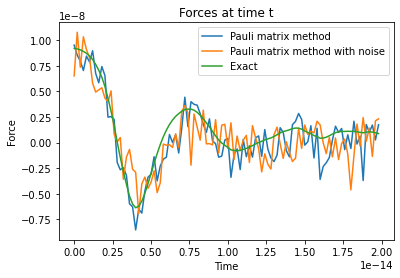

In [21]:
plt.plot(times,force_nonoise, label = 'Pauli matrix method')
plt.plot(times,force_noise, label = 'Pauli matrix method with noise')
plt.plot(times,force_exact, label = 'Exact')
plt.title('Forces at time t')
plt.xlabel('Time')
plt.ylabel('Force')
plt.legend()
plt.show()

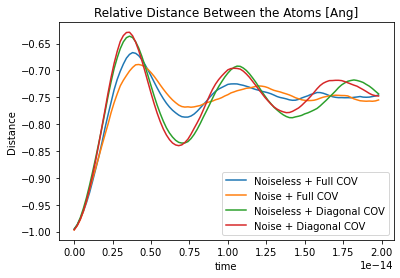

In [22]:

rel_dist_nonoise = coords_nonoise[1:,0] - coords_nonoise[1:,1]
rel_dist_noise = coords_noise[1:,0] - coords_noise[1:,1]
rel_dist_nonoise_diag = coords_nonoise_diag[1:,0] - coords_nonoise_diag[1:,1]
rel_dist_noise_diag = coords_noise_diag[1:,0] - coords_noise_diag[1:,1]
plt.plot(times,rel_dist_nonoise, label = 'Noiseless + Full COV')
plt.plot(times,rel_dist_noise, label = 'Noise + Full COV')
plt.plot(times,rel_dist_nonoise_diag, label = 'Noiseless + Diagonal COV')
plt.plot(times,rel_dist_noise_diag, label = 'Noise + Diagonal COV')
plt.title('Relative Distance Between the Atoms [Ang]')
plt.xlabel("time")
plt.ylabel("Distance")
plt.legend()
plt.show()